# MORPHOLOGY TEST

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from neuron import h, gui
from neuron.units import mV, ms, sec, um

%matplotlib inline
# c compiler
#!nrnivmodl vecevent.mod
#!nrnivmodl L5bPCmodelsEH/mod/

In [2]:
def createSynapse(dend,dendIdx, loc=0.5, tau=[2*ms, 4*ms], e=0*mV):
    """Creates an excitatory synapse on the dendrite given by Idx."""
    syn = h.Exp2Syn(dend[dendIdx](loc))
    syn.tau1 = tau[0]
    syn.tau2 = tau[1]
    syn.e = e
    return syn 

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
    stim = h.NetStim()
    stim.interval = isi
    stim.number = num
    stim.start = start
    stim.noise = noise
    stim.noiseFromRandom123(seed, 0, 0)
    stim.seed(seed)
    
    return stim

def connectStim(syn, stim, delay=1*ms, weight=0.4):
    conn = h.NetCon(stim, syn)
    conn.delay = delay
    conn.weight[0] = weight
    
    return conn

def createStim(isi=20*ms, num=100, start=1*ms, noise=1, seed=9):
        stim = h.NetStim()
        stim.interval = isi
        stim.number = num
        stim.start = start
        stim.noise = noise
        stim.noiseFromRandom123(seed, 0, 0)
        stim.seed(seed)
        return stim

def homogeneous_poisson(rate, tmax, bin_size):
    "Rate in Hz, Tmax and bin_size in ms"
    
    nbins = np.floor(tmax/bin_size).astype(int)
    
    prob_of_spike = rate * bin_size / 1e3 #In ms^-1
    
    spikes = np.random.rand(nbins) < prob_of_spike
    
    return spikes * 1

def Background_noise(rate,bin_size,tmax,numInputs):

    BoolTS = homogeneous_poisson(rate, tmax, bin_size)
    
    return [np.where(BoolTS==1)[0]*bin_size for i in range(numInputs)],BoolTS

def CreateVecStim(numInputs,tmax,rate=10,bin_size=0.1):

    Noise,BoolTS = Background_noise(rate,bin_size,tmax,numInputs)

    stimulations = [h.VecStim() for i in range(numInputs)]

    Noivec = [h.Vector(Noise[i]) for i in range(numInputs)]

    for i in range(numInputs):
        
        stimulations[i].play(Noivec[i])
    
    return stimulations,Noise,BoolTS

np.random.seed(12345)


In [3]:

def CorrInputs(tmax,rate,Nsour=2,bin_size=1,a=0,b=1000):
    
    Noiseb,BoolTS = Background_noise(rate,bin_size,tmax,1)
    
    NoiseCorr = []
    
    NoiseCorr.append(np.int32(np.round(Noiseb[0])))
    
    for i in range(Nsour-1):

        DerI = np.int32(np.round(Noiseb[0] + np.random.normal(a,b,len(Noiseb))))

        #Inputs should be inside the simulation time interval
        DerI *= 1*(DerI >= 0)*(DerI < tmax)

        #Delete inputs at 0 s
        DerI = [i for i in DerI if i!=0]

        NoiseCorr.append(np.array(DerI))
    
    stimulationsSour = [h.VecStim() for i in range(Nsour)]

    NoivecS = [h.Vector(NoiseCorr[i]) for i in range(Nsour)]

    for i in range(Nsour):
        
        stimulationsSour[i].play(NoivecS[i])
    
    return stimulationsSour

def BooleanInputInfo(NoiseCorrt,tmax,bin_size,numSour):
    
    St = np.arange(0,tmax,bin_size)

    Sbool = np.zeros([numSour,St.shape[0]],dtype=np.int8)

    for i in range(len(NoiseCorrt)):

        for j in NoiseCorrt[i]:

            Sbool[i,np.where(St==j)] = 1
    
    return Sbool

from scipy.ndimage import gaussian_filter1d
import numpy as np

def InputCorr(Inputs):
    
    S = np.zeros([len(Inputs),len(Inputs[0])])

    sigma = 1

    for i in range(len(Inputs)):

        S[i,np.where(Inputs[i]==1)[0]] = 1
        S[i,np.where((S[1:]-S[:-1])==1)[0]] = 0.5
        S[i,np.where((S[1:]-S[:-1])==-1)[0]+1] = 0.5

        S[i] = gaussian_filter1d(S[i],sigma)

    cor = np.corrcoef(S[0],S[1])[0,1]

    return cor

def EI_Synaptic_info(numNoiseInputs,tauE,tauI):
    
    pp = [0.8,0.2]

    es = [0,-80]

    ee = np.random.choice(es,numNoiseInputs,p=pp)

    tau = np.zeros([ee.shape[0],2])

    tau[np.where(ee<0)] = tauI
    tau[np.where(ee>=0)] = tauE
    
    return ee,tau


In [4]:

def ShanonEntropy(X):
    
    if len(X.shape)>1:
        t,size = X.shape
        
        base = np.array([2**i for i in range(size)])

        Xst = np.dot(X,base)

    else:
        size = 1
        
        Xst = 1*X
    
    states,counts = np.unique(Xst,return_counts=True)

    H = 0

    for i in range(len(states)):

        p = counts[i]/np.sum(counts)

        H += -p*np.log(p)
    
    return H

def IMf(x,y):
    
    h1 = ShanonEntropy(x)
    
    h2 = ShanonEntropy(y)

    h3 = ShanonEntropy(np.column_stack((x,y)))

    return h1+h2-h3

def PID(T,X):
    
    RR = np.min([IMf(T,X[:,0]),IMf(T,X[:,1])])
    
    ru1 = IMf(X[:,0],T)
    ru2 = IMf(X[:,1],T)
        
    U1 = ru1 - RR

    U2 = ru2 - RR
    
    Syn = IMf(X,T) - ru1 - ru2 + RR
        
    return [RR,U1,U2,Syn]

def PID_analysis(recordings,Input_bin_size=1,thres=-30,tau=1,Timebining=1,skip=2000):
    
    tmax = int(np.round(recordings["time"][-1]))
    
    numSour = len(recordings["inputTime"])
    
    Inputs = BooleanInputInfo(recordings["inputTime"],tmax,Input_bin_size,numSour)
    
    Vsoma = 1*(recordings["soma"] > thres)[ini:]

    t = recordings["time"]

    dt = np.mean(t[1:]-t[:-1])
    
    tw = int(np.round(Input_bin_size/dt))
    
    Ts0 = int(len(Vsoma)/tw)
    
    bolskip = int(ini*dt/Input_bin_size)
    
    T = int((len(Inputs[0])-bolskip)/Timebining)

    #Equalize input and soma time series    
    Somabool = np.zeros(Ts0,dtype=np.int8)
    
    for i in range(Ts0-1):

        Somabool[i] = np.sum(Vsoma[tw*i:tw*(i+1)])>0
    
    ######################################
    SS = [Somabool]
    
    for i in range(len(Inputs)):
        
        SS.append(Inputs[i][bolskip:])
    
    timeS = np.zeros([len(SS),T],dtype=np.int32)
    
    for j in range(len(SS)):

        for i in range(T-1):

            timeS[j,i] = np.int32(1*(np.sum(SS[j][i*Timebining:(i+1)*Timebining])>0))
    
    T = timeS[0,tau:]

    Xs = timeS[1:,:-tau].T

    Red,U1,U2,Syn = PID(T,Xs)
    
    cor = InputCorr(Inputs)

    return [Red,np.max([U1,U2]),Syn,cor]


In [5]:
def Plot3D(name,ddir="",inputsIdx=[],ax=None,scale=False):
    """
    3D plot of the neuron morphology highliting soma and inputs sections. 
    Warning: Needs h define as global object with cell morphology data already loaded in it.
    Params:
        - name: Filename to save the figure
        - inputsIdx: Index of sections receiving the inputs
    """
    
    Sections = [i for i in h.allsec()]

    Paths = [np.array(eval("h."+str(Sections[i])).psection()['morphology']['pts3d']) for i in range(len(Sections))]
    
    if ax==None:
        ax = pyplot.figure().add_subplot(projection='3d')
    
    SomaSec = [i for i in range(len(Sections)) if "soma" in str(Sections[i])]

    for i in SomaSec:
        
        if len(Paths[i])>0:
            ax.plot(Paths[i][:,0],Paths[i][:,2],Paths[i][:,1],'ro',ms=5,label="Soma",alpha=0.5)
        else:
            ax.plot(0.,0.,0.,'ro',ms=5,label="Soma",alpha=0.5)
            
    # Plot a sin curve using the x and y axes.
    for i in range(0,len(Paths)):

        if len(Paths[i])>0:
            xp = Paths[i][:,0]
            zp = Paths[i][:,1]
            yp = Paths[i][:,2]

            if i in inputsIdx:

                if i == inputsIdx[0]:
                    ax.plot(xp[-1],yp[-1],zp[-1],'^b',markersize=5,alpha=0.8,label="Inputs")
                else:
                    ax.plot(xp[-1],yp[-1],zp[-1],'^b',markersize=5,alpha=0.8)

            ax.plot(xp,yp,zp,'-k',linewidth=0.5)

    ps = []
    
    for j in [0,2,1]:

        pmin = np.min([np.min(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])
        pmax = np.max([np.max(Paths[i][:,j]) for i in range(len(Paths)) if len(Paths[i])>1])

        ps.append([pmin,pmax])

    ax.set_aspect('equal')

    if scale==True:
        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        
        scalebar = AnchoredSizeBar(ax.transData, 2e-2, r"200 $\mu$m", 3,frameon=False,pad=5)

        ax.add_artist(scalebar)

    ax.set_xticks(np.arange(100*(ps[0][0]//100),100*(ps[0][1]//100)+100,200))
    ax.set_yticks(np.arange(100*(ps[1][0]//100),100*(ps[1][1]//100)+100,200))
    ax.set_zticks(np.arange(100*(ps[2][0]//100),100*(ps[2][1]//100)+100,200));
    
    ax.set_xlabel(r"$\mu$m")
    ax.set_ylabel(r"$\mu$m")
    ax.set_zlabel(r"$\mu$m")
    
    ax.legend(markerscale=1,frameon=False)

    pyplot.savefig(ddir+"Neuron_"+name+"_inputs.png",dpi=500,bbox_inches="tight")

    return ax

In [6]:
h.nrn_load_dll("x86_64/vecevent.so")

0.0

In [7]:

#filename = "DATA/Pyrp22.hoc"

#h.load_file(filename)

ddir = "L5bPCmodelsEH/"
    
h.load_file("import3d.hoc")
h.load_file("nrngui.hoc")
h.load_file(ddir+"init.hoc")

morphology_file = ddir+"morphologies/cell1.asc"

h.load_file(ddir+"models/L5PCbiophys3.hoc")
h.load_file(ddir+"models/L5PCtemplate.hoc")

h.L5PCtemplate(morphology_file)

#allsec = h.allsec()


	0 
	1 


L5PCtemplate[0]

In [8]:
#h('forall delete_section()')


In [9]:

#SELECTING SECTION FOR BACKGROUND NOISE
def Select_Noise_sections(List,Sections,Cell="Pyr_p1",typ=0,rangeL=[0,1500],numNoiseInputs=100):
    
    if typ==0:
        Cell0 = List[(List['Cell_name']==Cell)&((List['Labels'].str.contains("dend"))|(List['Labels'].str.contains("apic")))]
    else:
         Cell0 = List[(List['Cell_name']==Cell)&(List['Labels'].str.contains(typ))]
       
    #For background noise
    rangeL = [0,1500]

    SecNames = Cell0[(Cell0['PathLength']>rangeL[0])&(Cell0['PathLength']<rangeL[1])].Labels.values

    dendIdx0 = []

    for i in range(len(Sections)):
        sec = Sections[i]
        if str(sec) in SecNames:
            dendIdx0.append(i)
    
    dendIdx = np.random.choice(dendIdx0,numNoiseInputs)
    
    return dendIdx

#SELECTING SECTION FOR INPUTs
def Select_Input_sections(List,Sections,dendIdx,typ="dend",Cell="Pyr_p1_",rangeL=[0,1000],numInputs=2):
    
    Cell0 = List[(List['Cell_name']==Cell)&(List['Labels'].str.contains(typ))]
    
    SecNamesSour = Cell0[(Cell0['PathLength']>rangeL[0])&(Cell0['PathLength']<rangeL[1])].Labels.values

    dendIdxSour0 = []
    
    for i in range(len(Sections)):
        sec = Sections[i]
        if str(sec) in SecNamesSour:
            dendIdxSour0.append(i)   

    dendIdxSour = np.random.choice(dendIdxSour0,numInputs,replace=False)
    
    #To avoid selecting a section in noise input sections
    Crit = True
    while Crit:
        for a in dendIdxSour:
            if a in dendIdx:
                dendIdxSour[:] = np.random.choice(dendIdxSour0,numInputs,replace=False)
            else:
                Crit = False
    
    return dendIdxSour


In [10]:
import pandas as pd

List = pd.read_csv("DATA/Morpho_data_Pyr_p1_.csv")

CellName = List["Cell_name"][0]

#h.load_file(filename) 

Sections = [i for i in h.allsec()]

Soma = [i for i in Sections if "soma" in str(i)]


In [18]:
rate = 10

tmax = 20000 #ms

#Number of sources
numSour = 2

#Parameters for decorrelate inputs
noiM = 0 #Mean of time deviation (gaussian dist)
noiStd = 10#Standart deviation of time deviation (gaussian dist)

#NUmber of noisy synapses and inputs
numNoiseInputs = 100

#numNoiseInputsApic = 20

dt = 0.0125

h.dt = dt

#Parameters
loc = 0.5
e = 0
delay = 0
weight = 0.025

#Different time constants for E and I synapses
tauE = [2,4]
tauI = [2,4]

dendIdx = Select_Noise_sections(List,Sections,Cell=CellName,numNoiseInputs=numNoiseInputs)


In [25]:
DendriticRegions = {"Basal":[50,200],"Midle":[200,600],"Apical":[600,1500]}

Region = "Basal"

In [32]:
#IdxSour = Select_Input_sections(List,Sections,dendIdx,Cell=CellName,rangeL=DendriticRegions[Region])

#NumSen = 10

#MonitPoints = Select_Noise_sections(List,Sections,Cell=CellName,numNoiseInputs=NumSen)

MonitPoints = [i for i in range(len(Sections)) if "soma" not in str(Sections[i])]

NumSen = len(MonitPoints)

#Basal 10 45 from denGen
#Apical 150 140 from denGen
#Midle 90 100 from debGen
#IdxSour = {"Basal":np.array([10,45]),"Apical":np.array([150,140]),"Midle":np.array([90, 100])}
#idxS = IdxSour[Region]

ee,tau = EI_Synaptic_info(numNoiseInputs,tauE,tauI)

#Creating Input (spiking time)
stimulationsCorr = CorrInputs(tmax,rate)


<Axes3D: xlabel='$\\mu$m', ylabel='$\\mu$m', zlabel='$\\mu$m'>

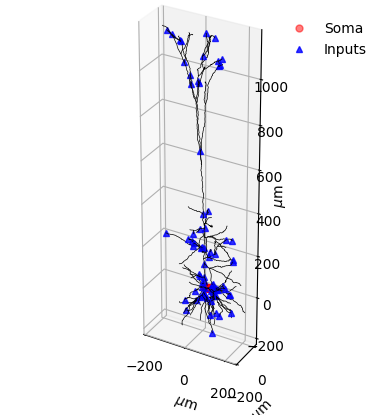

In [29]:
Plot3D("Pyramidal_1",inputsIdx=dendIdx)

In [30]:

# input stimulus (NetStim) parameters
isi=100*ms         # mean interspike time interval
num=1000            # average number of spikes
start=1*ms        # stimulus start time
stop=tmax*ms      # simulation stop time
noise=1         # noise parameter (must be a value from 0 to 1)

seeds=np.random.randint(10000, size=numNoiseInputs)


In [33]:
#BACKGROUND NOISE
# create synapses
synapses = [createSynapse(Sections,dendIdx[i], loc=loc, tau=tau[i], e=ee[i]) for i in range(numNoiseInputs)]

# create inputs
stimulations = [createStim(isi=isi, num=num, start=start, noise=noise, seed=seeds[i]) for i in range(numNoiseInputs)]

# connect inputs to synapses
connections = [connectStim(synapses[i], stimulations[i], delay=delay, weight=weight) for i in range(numNoiseInputs)]

#create synapses in non apical den (?)
#synapsesSour = [createSynapse(Sections,IdxSour[i], loc=loc, tau=tauE, e=0.) for i in range(numSour)]

# connect inputs to synapses
#connectionsSour = [connectStim(synapsesSour[i], stimulationsCorr[i], delay=delay, weight=0.2) for i in range(numSour)]


In [35]:
# prepare output variable
recordings = {'soma': h.Vector(),
#              'input': [h.Vector() for i in range(numSour)],
#              'inputTime': [h.Vector() for i in range(numSour)],
#              'dendrite': [h.Vector() for i in range(numSour)],
              'sensors': [h.Vector() for i in range(NumSen)],
#              'synapse': [h.Vector() for i in range(numSour)],
              'time': h.Vector()}

# set up recordings
recordings['soma'].record(Soma[0](0.5)._ref_v) # soma membrane potential
recordings['time'].record(h._ref_t) # time steps

#for i, dend0 in enumerate(IdxSour):
#    recordings['dendrite'][i].record(Sections[dend0](0.5)._ref_v)
#    recordings['synapse'][i].record(synapsesSour[i]._ref_i)
#    connectionsSour[i].record(recordings['inputTime'][i], recordings['input'][i])

for i, sen0 in enumerate(MonitPoints):
    recordings['sensors'][i].record(Sections[sen0](0.5)._ref_v)


In [36]:
h.finitialize(-65 * mV)

h.continuerun(tmax)


0.0

In [39]:
# convert outputs into numpy arrays
for k,v in recordings.items():
    if k=='soma' or k=='time':
        recordings[k] = np.array(list(recordings[k]))
    else:
        recordings[k] = [np.array(list(recordings[k][i])) for i in range(len(recordings[k]))]


In [45]:
ini = tmax-1000


In [46]:
ifi = tmax

/tmp/ipykernel_4063/2242457272.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


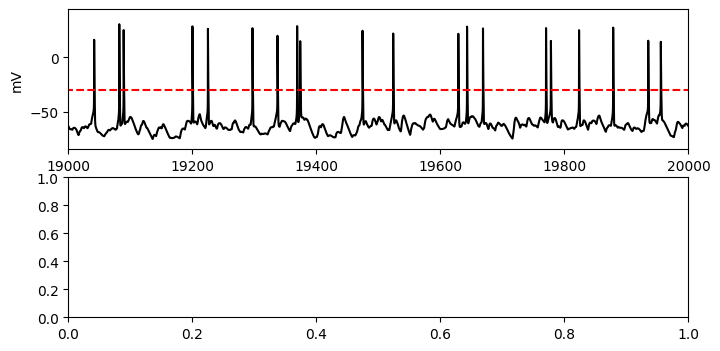

In [47]:
fig,ax = pyplot.subplots(2,1,figsize=(8,4)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black')

thres = -30

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

ax[0].set_xlim(ini, ifi)
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('mV')

cmap = cm.get_cmap('winter')
spacing = cmap.N//numSour

colours = cmap(np.arange(0, cmap.N, spacing))
    
# rasterplot with input stimuli
#for i in range(2):
#    ax[1].vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  

#ax[1].set_yticks(range(len(recordings['input'])))
#ax[1].set_xlim(ini, ifi)
#ax[1].set_xlabel('time (ms)')
#ax[1].set_ylabel('input id')


(19000.0, 20000.0)

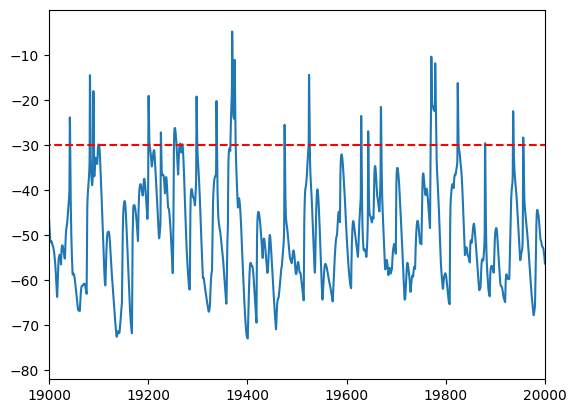

In [58]:
i = 30

pyplot.plot(recordings["time"],recordings['sensors'][i])

pyplot.hlines(thres,0,tmax,color="red",linestyle='dashed')

pyplot.xlim(ini, ifi)

In [26]:
import pickle

rep = 1

filename = "DATA/Sim_Pyr_p1_dt_"+str(dt)+"_tmax_"+str(tmax)+"_Inputs_"+Region+"_rep_"+str(rep)

# opening file in write mode (binary) 
file = open(filename, "wb") 
  
# serializing dictionary  
pickle.dump(recordings, file) 

# closing the file 
file.close()


In [27]:
import os 
import pickle

ddir = "DATA/"

allfiles = os.listdir(ddir)

files = [i for i in allfiles if "Basal" in i]

files


['Sim_Pyr_p1_dt_0.0125_tmax_20000_Inputs_Basal_rep_1']

In [28]:
import numpy as np
import matplotlib.pyplot as plt

i = 0

with open(ddir+files[i], 'rb') as handle: 
    data = handle.read() 

recordings = pickle.loads(data) 

ini = tmax-2000
ifi = tmax


/tmp/ipykernel_9414/4218825620.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('winter')


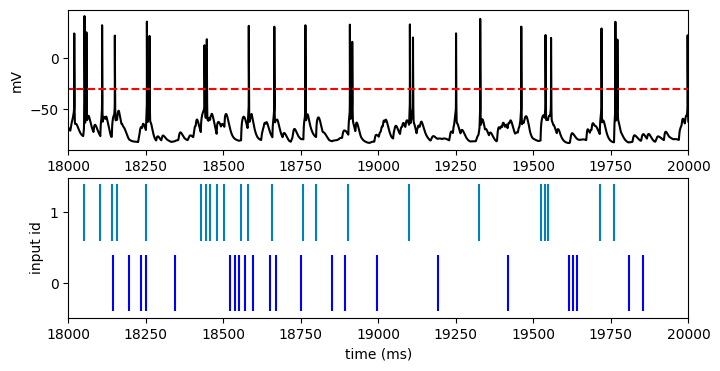

In [29]:
from matplotlib import pyplot, cm

#tmax = 10000
numSour = 2

fig,ax = pyplot.subplots(2,1,figsize=(8,4)) # Default figsize is (8,6)

soma_plot = ax[0].plot(recordings["time"], recordings["soma"], color='black')

thres = -30

ax[0].hlines(thres,0,tmax,color="red",linestyle='dashed')

ax[0].set_xlim(ini, ifi)
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('mV')

cmap = cm.get_cmap('winter')
spacing = cmap.N//numSour

colours = cmap(np.arange(0, cmap.N, spacing))
    
# rasterplot with input stimuli
for i in range(2):
    ax[1].vlines(recordings['inputTime'][i], i-0.4, i+0.4, colors=colours[i])  

ax[1].set_yticks(range(len(recordings['input'])))
ax[1].set_xlim(ini, ifi)
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('input id')

plt.savefig("Simulation_basal.png",dpi=300,bbox_inches="tight")


In [30]:
#Time bin
Ttb = np.arange(0,50,5)

Ttb[0] = 1

PIDS = []

ini = 2000

for tb in Ttb:

    PIDs = PID_analysis(recordings,tau=1,Timebining=tb)
    
    PIDS.append(PIDs)


Inputs correlation= 0.02754435536565415


Text(0, 0.5, 'Information (bits)')

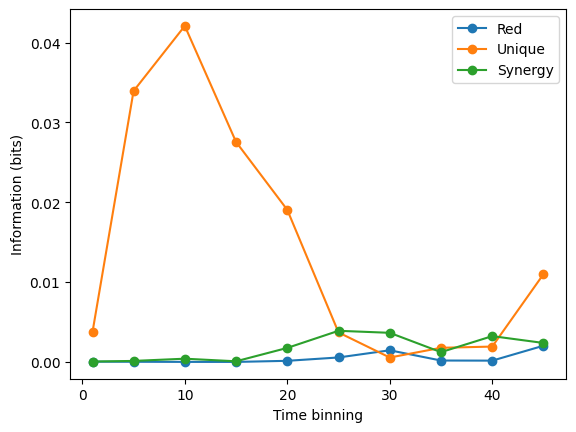

In [31]:
labels = ["Red","Unique","Synergy"]

PIDS = np.array(PIDS)

for i in range(len(labels)):
    
    plt.plot(Ttb,PIDS[:,i],'o-',label=labels[i])

plt.legend()

print("Inputs correlation=",np.mean(PIDS[:,-1]))

plt.xlabel("Time binning")
plt.ylabel("Information (bits)")

#plt.savefig("PID_timebinnig.png",dpi=400,bbox_inches="tight")

In [32]:
#Timebin that maximize information atom measured
MaxTimeBin = Ttb[np.where(PIDS == np.max(PIDS[:,:3]))[0][0]]

MaxTimeBin

10

In [33]:
#Time bin
Taus = np.arange(1,30,3)

PIDSt = []

for taus in Taus:

    PIDst = PID_analysis(recordings,tau=taus,Timebining=1)
    
    PIDSt.append(PIDst)


Inputs correlation= 0.02754435536565415


Text(0, 0.5, 'Information (bits)')

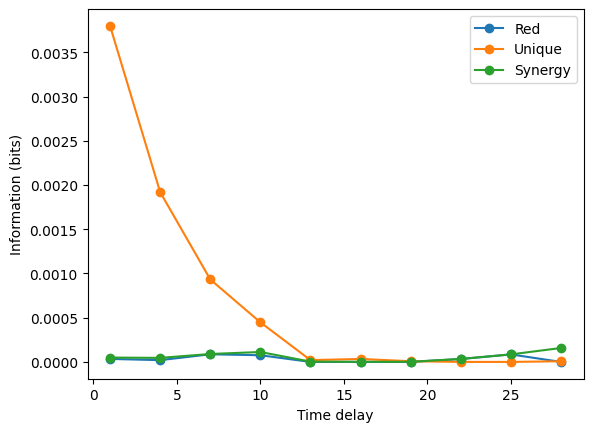

In [34]:
labels = ["Red","Unique","Synergy"]

PIDSt = np.array(PIDSt)

for i in range(len(labels)):
    
    plt.plot(Taus,PIDSt[:,i],'-o',label=labels[i])

plt.legend()

print("Inputs correlation=",np.mean(PIDSt[:,-1]))

plt.xlabel("Time delay")
plt.ylabel("Information (bits)")

#plt.savefig("PID_time_delay.png",dpi=400,bbox_inches="tight")


In [35]:
#Delay that maximize information atom measured
MaxTau = Taus[np.where(PIDSt == np.max(PIDSt[:,:3]))[0][0]]

MaxTau

1